In [1]:
import yfinance as yf
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np

# Download data
tech_tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG']
bank_tickers = ['JPM', 'BAC', 'GS', 'MS']
finance_tickers = ['MA', 'AXP']

tech_data = yf.download(tech_tickers, start='2015-01-01', end='2023-03-01')['Adj Close']
finance_data = yf.download(finance_tickers, start='2015-01-01', end='2023-03-01')['Adj Close']
bank_data = yf.download(bank_tickers, start='2015-01-01', end='2023-03-01')['Adj Close']

# Combine data into a single DataFrame
data = pd.concat([tech_data, finance_data, bank_data], axis=1)
data.columns = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'JPM', 'BAC', 'GS', 'MS', 'MA', 'AXP']
data

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  4 of 4 completed


,AAPL,MSFT,AMZN,GOOG,JPM,BAC,GS,MS,MA,AXP
Date,,,,,,,,,,
2015-01-02,24.565693,15.426000,26.168653,40.709469,82.201302,81.394264,15.267412,167.411484,49.936512,31.525974
2015-01-05,23.873644,15.109500,25.623152,40.335102,80.027397,79.104797,14.823891,162.184433,48.386230,30.540533
2015-01-06,23.875893,14.764500,25.029282,39.743099,78.321869,78.933815,14.380368,158.903580,47.131618,29.660961
2015-01-07,24.210682,14.921000,24.986401,40.248043,80.032433,80.161652,14.448602,161.271637,47.203548,30.084457
2015-01-08,25.140911,15.023000,25.065184,41.432068,81.166885,81.408524,14.747127,163.846405,48.258369,30.532389
...,...,...,...,...,...,...,...,...,...,...
2023-02-22,148.910004,95.790001,91.800003,251.509995,174.699997,354.970001,34.069035,358.324310,138.559998,97.269997
2023-02-23,149.399994,95.820000,91.070000,254.770004,175.139999,355.529999,34.039227,360.955475,139.669998,97.940002
2023-02-24,146.710007,93.500000,89.349998,249.220001,174.250000,353.119995,33.989548,361.263275,140.929993,97.699997


In [2]:
n_components = 3
# Calculate daily returns
returns = data.pct_change().dropna()
# Fit PCA model
pca = PCA(n_components=n_components)
pca.fit(returns)

PCA(n_components=3)

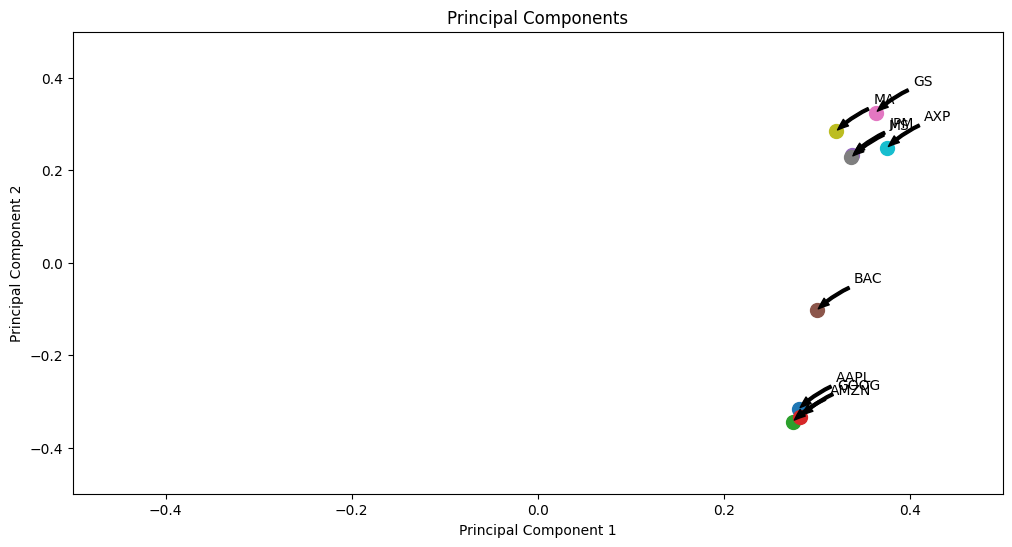

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot principal components
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
for i, (x, y) in enumerate(zip(pca.components_[0], pca.components_[1])):
    ax.scatter(x, y, marker='o', s=100)
    ax.annotate(returns.columns[i], xy=(x, y), xytext=(x+0.04, y+0.06),
                arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=6, headlength=8, connectionstyle='arc3,rad=0.1'))

ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-0.5, 0.5])
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Principal Components')
plt.show()

In [7]:
# Calculate alpha factors
alpha_factors = pd.DataFrame()
for i in range(3):
    alpha_factors[f'alpha_{i+1}'] = returns.dot(pca.components_[i])

# Add alpha factors to returns data
alpha_returns = pd.concat([alpha_factors, returns], axis=1)

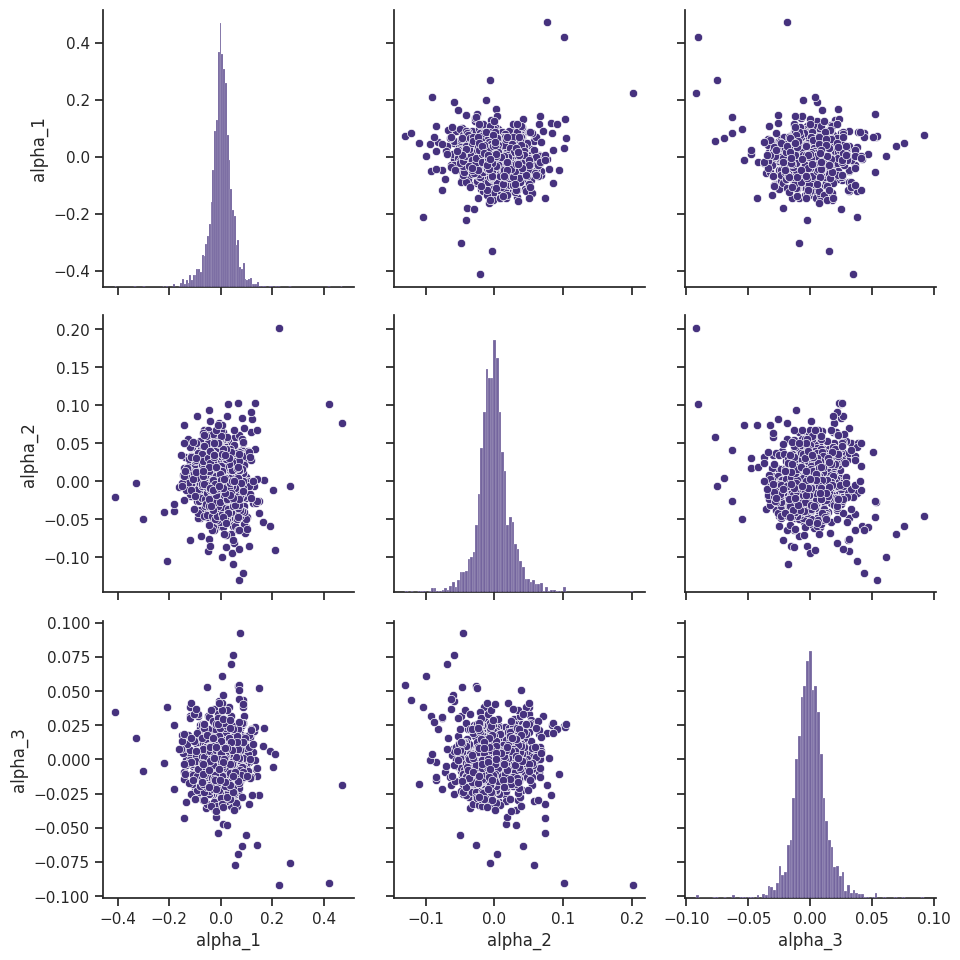

In [8]:
# Plot scatter matrix of alpha factors
sns.set(style='ticks', palette='viridis')
g = sns.pairplot(alpha_factors)
g.fig.set_size_inches(10,10)
plt.show()


In [9]:
import statsmodels.api as sm

# Calculate alpha
alpha = pd.DataFrame()
for i in range(n_components):
    model = sm.OLS(alpha_returns.iloc[:, 3+i], alpha_returns.iloc[:, :3])
    results = model.fit()
    alpha[f'alpha_{i+1}'] = results.params
alpha_mean = alpha.mean()
alpha_std = alpha.std()
print(f'Mean alpha: \n{alpha_mean}')
print('='*50)
print(f'Std alpha: \n{alpha_std}')

Mean alpha: 
alpha_1   -0.081650
alpha_2    0.067872
alpha_3   -0.030644
dtype: float64
Std alpha: 
alpha_1    0.318351
alpha_2    0.548392
alpha_3    0.308905
dtype: float64


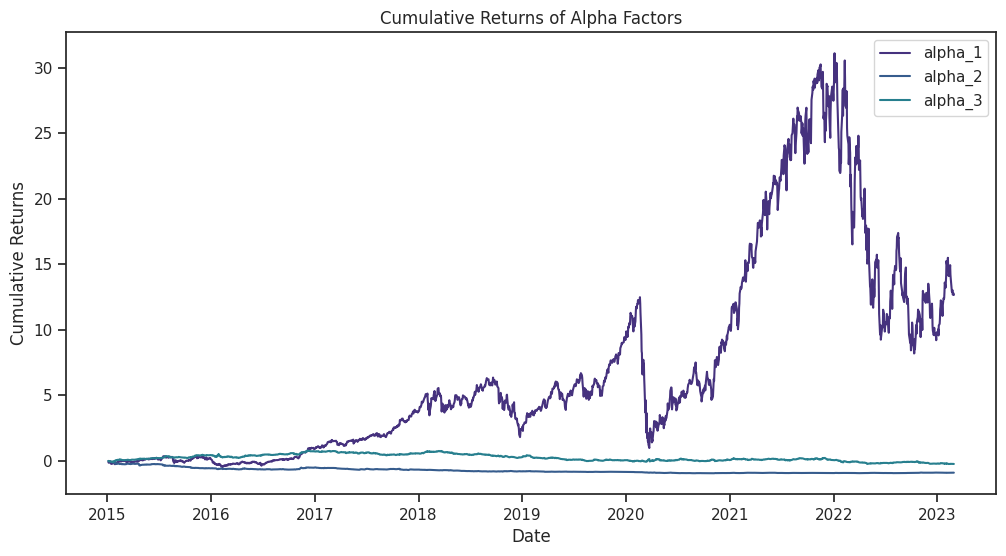

In [10]:
# Cumulative returns
alpha_cum_returns = (1 + alpha_factors).cumprod() - 1

# Plot returns
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
ax.plot(alpha_cum_returns)
ax.legend(alpha_cum_returns.columns)
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Cumulative Returns of Alpha Factors')
plt.show()

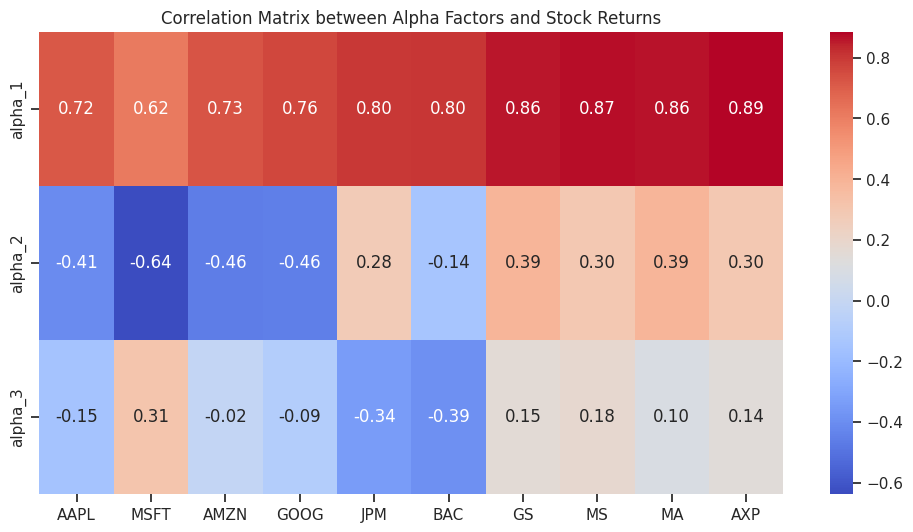

In [11]:
# Calculate correlation 
corr_matrix = alpha_returns.corr()
alpha_corr = corr_matrix.iloc[:n_components, n_components:]

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
sns.heatmap(alpha_corr, cmap='coolwarm', annot=True, fmt='.2f', ax=ax)
plt.title('Correlation Matrix between Alpha Factors and Stock Returns')
plt.show()

In [12]:
# Calculate alpha factors sharpe ratio
sharpe_ratio = alpha.mean() / alpha.std() * np.sqrt(252)
print(f'Sharpe ratio: \n{sharpe_ratio}')

Sharpe ratio: 
alpha_1   -4.071461
alpha_2    1.964715
alpha_3   -1.574797
dtype: float64
